<a href="https://colab.research.google.com/github/juanespinoza96/Modelo-DeteccionSarcasmo-CAnalisisSentimiento/blob/main/Tesis_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# 0. INSTALACIÓN DE DEPENDENCIAS (Solo Colab)
# ==========================================
# 'emoji'para convertir iconos a texto
!pip install emoji nltk

In [ ]:
!pip install pandas matplotlib seaborn wordcloud

# Fase 1 (EDA)

In [ ]:
import pandas as pd
import re
import emoji
import nltk
import string
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Configuracion y descargas de NLTK

In [ ]:
# ==========================================
# 1. CONFIGURACIÓN Y DESCARGAS (Setup)
# ==========================================
# Descargamos los recursos necesarios para procesar lenguaje
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializamos el Lematizador
lemmatizer = WordNetLemmatizer()

# --- CONFIGURACIÓN DE IDIOMA (INGLÉS) ---
IDIOMA = 'english'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
stop_words = set(stopwords.words(IDIOMA))

# Definimos negaciones en INGLÉS (Importante para Sarcasmo)
negation_words = {
    'no', 'not', 'nor', 'neither', 'never', 'none',
    "n't", 'cannot', "daren't", "dasn't", "didn't",
    "doesn't", "don't", "hadn't", "hasn't", "haven't",
    "isn't", "mightn't", "mustn't", "needn't", "shan't",
    "shouldn't", "wasn't", "weren't", "won't", "wouldn't"
}
# Quitamos las negaciones de la lista de palabras a borrar
stop_words = stop_words - negation_words

##CARGA DE DATOS (Aquí definimos 'df')

In [ ]:
# ==========================================
# 2. CARGA DE DATOS
# ==========================================
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Proyecto_Sarcasmo/train.csv')


# Rutas
ruta_train = '/content/drive/MyDrive/Proyecto_Sarcasmo/train.csv'

# Verificar si el archivo existe
if os.path.exists(ruta_train):
    # 1. Cargar el archivo
    # Usamos sep=',' para asegurar que corte bien las columnas
    df = pd.read_csv(ruta_train, sep=',', on_bad_lines='skip', engine='python')

    # 2. IMPRIMIR COLUMNAS ORIGINALES
    print(f"Columnas encontradas originalmente: {df.columns.tolist()}")

    # 3. RENOMBRADO DE COLUMNAS (La solución a error)
    # Si el archivo trae 'tweets' (plural), lo cambiamos a 'tweet' (singular)
    # Si el archivo trae 'class', lo cambiamos a 'label'
    nuevos_nombres = {
        'tweets': 'tweet',
        'class': 'label',
        'real_class': 'label'
    }
    df = df.rename(columns=nuevos_nombres)

    # 4. Limpieza de espacios en blanco en los nombres
    df.columns = df.columns.str.strip()

    print("\n--- Estructura corregida del DataFrame ---")
    print(df.head(2)) # Muestra las primeras 2 filas

    # Verificación final antes de pasar al Paso 4
    if 'tweet' in df.columns:
        print("\nTODO LISTO: La columna 'tweet' existe. Puedes ejecutar el Paso 4.")
    else:
        print("\nALERTA: Aún no veo la columna 'tweet'. Revisa la impresión de columnas originales arriba.")

else:
    print("No se encuentra el archivo en la ruta especificada.")

Mounted at /content/drive
Columnas encontradas originalmente: ['tweets', 'class']

--- Estructura corregida del DataFrame ---
                                               tweet       label
0  Be aware  dirty step to get money  #staylight ...  figurative
1  #sarcasm for #people who don't understand #diy...  figurative

TODO LISTO: La columna 'tweet' existe. Puedes ejecutar el Paso 4.


## Funcion de limpieza

In [ ]:
# ==========================================
# 3. LIMPIEZA BLINDADA (SIN PALABRAS TRAMPA)
# ==========================================
import re
import emoji
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Configuración inicial
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
IDIOMA = 'english'
stop_words = set(stopwords.words(IDIOMA))

# Negaciones a MANTENER
negation_words = {
    'no', 'not', 'nor', 'neither', 'never', 'none',
    "n't", 'cannot', "daren't", "dasn't", "didn't",
    "doesn't", "don't", "hadn't", "hasn't", "haven't",
    "isn't", "mightn't", "mustn't", "needn't", "shan't",
    "shouldn't", "wasn't", "weren't", "won't", "wouldn't"
}
stop_words = stop_words - negation_words

# --- NUEVA LISTA DE PALABRAS PROHIBIDAS (AYUDAS) ---
# Estas son las palabras que le dan la respuesta al modelo.
# Las borraremos para obligar al modelo a entender el contexto real.
palabras_trampa = {
    'sarcasm', 'sarcastic', 'irony', 'ironic', 'figurative',
    '#sarcasm', '#irony', '#not', '#sarcastic', '#ironic'
}

def limpiar_texto_tesis(text):
    if not isinstance(text, str):
        return ""

    # 1. Convertir a minúsculas primero para detectar trampas
    text = text.lower()

    # 2. BORRADO DE TRAMPAS
    # Reemplazamos las palabras trampa por espacio vacío
    for trampa in palabras_trampa:
        text = text.replace(trampa, '')

    # 3. Emojis a Texto
    text = emoji.demojize(text)

    # 4. Eliminar URLs y Menciones
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)

    # 5. Tokenización
    tokens = word_tokenize(text)

    processed_tokens = []
    for word in tokens:
        # Lematización
        lemma = lemmatizer.lemmatize(word)

        # Filtrado (Stopwords) preservando negaciones y puntuación
        if word in stop_words and word not in negation_words:
            continue

        if lemma.isalnum() or lemma in negation_words or any(char in string.punctuation for char in lemma):
            processed_tokens.append(lemma)

    return " ".join(processed_tokens)

# --- VERIFICACIÓN---
tweet_tramposo = "I love delays! #sarcasm irony"
print(f"Original: {tweet_tramposo}")
print(f"Limpio:   {limpiar_texto_tesis(tweet_tramposo)}")
# Debería salir: "love delay !"

Original: I love delays! #sarcasm irony


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Limpio:   love delay ! #


##APLICACIÓN AL DATAFRAME

In [ ]:
# ==========================================
# 4. APLICACIÓN AL DATAFRAME
# ==========================================
print("\n--- Aplicando limpieza... ---")
df['tweet_clean'] = df['tweet'].apply(limpiar_texto_tesis)

print("\n--- RESULTADO FINAL ---")
print(df[['tweet', 'tweet_clean']])


--- Aplicando limpieza... ---

--- RESULTADO FINAL ---
                                                   tweet  \
0      Be aware  dirty step to get money  #staylight ...   
1      #sarcasm for #people who don't understand #diy...   
2      @IminworkJeremy @medsingle #DailyMail readers ...   
3      @wilw Why do I get the feeling you like games?...   
4      -@TeacherArthurG @rweingarten You probably jus...   
...                                                  ...   
81403  Photo: Image via We Heart It http://t.co/ky8Nf...   
81404  I never knew..I better put this out to the Uni...   
81405  hey just wanted to say thanks @ puberty for le...   
81406  I'm sure coverage like the Fox News Special “T...   
81407  @skeyno16 at u13?! I won't believe it until I ...   

                                             tweet_clean  
0      aware dirty step get money # staylight # stayw...  
1            # # people n't understand # diy # artattack  
2      # dailymail reader sensible always # sh

#Fase 2 (Preprocesamiento)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import emoji
import re
import string

##CONFIGURACIÓN Y DESCARGAS

In [ ]:
# ==========================================
# 1. CONFIGURACIÓN Y DESCARGAS
# ==========================================
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # Necesario para lematización
nltk.download('omw-1.4')

# Inicializar Lematizador
lemmatizer = WordNetLemmatizer()

# Idioma
IDIOMA = 'english'
stop_words = set(stopwords.words(IDIOMA))

# Definir Negaciones
negation_words = {
    'no', 'not', 'nor', 'neither', 'never', 'none',
    "n't", 'cannot', "daren't", "dasn't", "didn't",
    "doesn't", "don't", "hadn't", "hasn't", "haven't",
    "isn't", "mightn't", "mustn't", "needn't", "shan't",
    "shouldn't", "wasn't", "weren't", "won't", "wouldn't"
}
stop_words = stop_words - negation_words
# --- NUEVA LISTA DE PALABRAS PROHIBIDAS (SPOILERS) ---
# Estas son las palabras que le dicen la respuesta al modelo.
# Las borraremos para obligar al modelo a entender el contexto real.
palabras_trampa = {
    'sarcasm', 'sarcastic', 'irony', 'ironic', 'figurative',
    '#sarcasm', '#irony', '#not', '#sarcastic', '#ironic'
}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


##FUNCIÓN DE LIMPIEZA ADAPTADA AL CONTEXTO

In [ ]:
# ==========================================
# 2. FUNCIÓN DE LIMPIEZA ADAPTADA AL CONTEXTO
# ==========================================
def limpiar_texto_tesis(text):
    if not isinstance(text, str):
        return ""

  #  Convertir a minúsculas primero para detectar trampas
    text = text.lower()
    # A. Emojis a Texto
    text = emoji.demojize(text)

    # B. Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # 2. BORRADO DE TRAMPAS
    # Reemplazamos las palabras trampa por espacio vacío
    for trampa in palabras_trampa:
        text = text.replace(trampa, '')

    # C. Eliminar menciones
    text = re.sub(r'@\w+', '', text)

    # D. Tokenización
    tokens = word_tokenize(text.lower())

    # E. Filtrado, Lematización y Preservación de Puntuación
    processed_tokens = []

    for word in tokens:
    # Lematización
        lemma = lemmatizer.lemmatize(word)

        # Filtrado (Stopwords) preservando negaciones y puntuación
        if word in stop_words and word not in negation_words:
            continue

        if lemma.isalnum() or lemma in negation_words or any(char in string.punctuation for char in lemma):
            processed_tokens.append(lemma)

    return " ".join(processed_tokens)
    # --- VERIFICACIÓN ---
tweet_tramposo = "I love delays! #sarcasm irony"
print(f"Original: {tweet_tramposo}")
print(f"Limpio:   {limpiar_texto_tesis(tweet_tramposo)}")
# Debería salir: "love delay !"

Original: I love delays! #sarcasm irony
Limpio:   love delay !


##VERIFICACIÓN DE CONGRUENCIA

In [ ]:
# ==========================================
# 3. VERIFICACIÓN DE CONGRUENCIA
# ==========================================

ejemplo_contexto = "I am loving waiting in traffic!!! I don't like it 😂 http://url.com"

print(f"Original: {ejemplo_contexto}")
print(f"Procesado: {limpiar_texto_tesis(ejemplo_contexto)}")

# Aplicar al DataFrame
if 'df' in locals():
    print("\nProcesando dataset completo...")
    df['tweet_clean'] = df['tweet'].apply(limpiar_texto_tesis)
    print("Preprocesamiento completado según metodología del estudio.")

Original: I am loving waiting in traffic!!! I don't like it 😂 http://url.com
Procesado: loving waiting traffic ! ! ! n't like : face_with_tears_of_joy :

Procesando dataset completo...
Preprocesamiento completado según metodología del estudio.


# Fase 3 (Vectorizacion)

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


##CARGA Y FUSIÓN (Merge & Resplit)

In [ ]:
# ==========================================
# 1. CARGA, FUSIÓN Y LIMPIEZA INICIAL
# ==========================================
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Rutas de archivos
ruta_train = '/content/drive/MyDrive/Proyecto_Sarcasmo/train.csv'
ruta_test = '/content/drive/MyDrive/Proyecto_Sarcasmo/test.csv'

def cargar_y_estandarizar(ruta):
    """Carga el CSV y renombra las columnas a 'tweet' y 'label'"""
    if not os.path.exists(ruta):
        print(f"Archivo no encontrado: {ruta}")
        return pd.DataFrame()

    # 1. Cargar
    df = pd.read_csv(ruta, sep=',', on_bad_lines='skip', engine='python')

    # 2. Renombrar
    nuevos_nombres = {
        'tweets': 'tweet',
        'class': 'label',
        'real_class': 'label'
    }
    df = df.rename(columns=nuevos_nombres)

    # 3. Limpiar espacios en nombres de columna
    df.columns = df.columns.str.strip()

    # 4. Filtrar solo lo útil
    if 'tweet' in df.columns and 'label' in df.columns:
        return df[['tweet', 'label']]
    else:
        print(f"Error en columnas de {os.path.basename(ruta)}: {df.columns.tolist()}")
        return pd.DataFrame()

# --- EJECUCIÓN PRINCIPAL ---
print("--- Iniciando Fusión de Datos para Fase 3 ---")

df_train = cargar_y_estandarizar(ruta_train)
df_test = cargar_y_estandarizar(ruta_test)

# Fusión: Creamos df_total uniendo ambos
df_total = pd.concat([df_train, df_test], ignore_index=True)

# Inicializar VADER
analyzer = SentimentIntensityAnalyzer()

# Aplicamos la limpieza ahora mismo para que df_total tenga la columna 'tweet_clean'
print("--- Aplicando limpieza 'anti-trampas' (Generando tweet_clean) ---")

# Verificamos si la función de limpieza existe
if 'limpiar_texto_tesis' in globals():
    df_total['tweet_clean'] = df_total['tweet'].apply(limpiar_texto_tesis)
    print("✅ Columna 'tweet_clean' creada exitosamente.")
else:
    print("ALERTA CRÍTICA: La función 'limpiar_texto_tesis' no se encuentra en memoria.")
    print("   Por favor, vuelve a ejecutar la celda de la FASE 2 antes de correr esto.")

print(f"\nDataset fusionado listo.")
print(f"Total registros: {len(df_total)}")
# Ahora imprimimos las columnas para confirmar que tweet_clean existe
print("Columnas actuales:", df_total.columns.tolist())

--- Iniciando Fusión de Datos para Fase 3 ---
--- Aplicando limpieza 'anti-trampas' (Generando tweet_clean) ---
✅ Columna 'tweet_clean' creada exitosamente.

Dataset fusionado listo.
Total registros: 89536
Columnas actuales: ['tweet', 'label', 'tweet_clean']


##INGENIERÍA DE FEATURES (Híbrido)

In [ ]:
# ==========================================
# 2. INGENIERÍA DE FEATURES (Híbrido)
# ==========================================
print("Generando features léxicas y de sentimiento...")

def get_features(text):
    text = str(text)
    if not text: return pd.Series([0, 0, 0, 0, 0])

    # Features Léxicas
    length = len(text)
    caps_ratio = sum(1 for c in text if c.isupper()) / length if length > 0 else 0
    excl_count = text.count('!')
    quest_count = text.count('?')

    # Sentimiento VADER (Compound score: -1 a 1)
    sentiment = analyzer.polarity_scores(text)['compound']

    return pd.Series([length, caps_ratio, excl_count, quest_count, sentiment])

# Aplicar al dataframe total
cols = ['length', 'caps_ratio', 'excl_count', 'quest_count', 'sentiment']
df_total[cols] = df_total['tweet'].apply(get_features)

Generando features léxicas y de sentimiento...


##ESCALADO DE DATOS

In [ ]:
# ==========================================
# 3. ESCALADO DE DATOS
# ==========================================
# Las redes neuronales requieren que las entradas numéricas estén en rangos similares (0 a 1).
# Si no hacemos esto, el modelo ignorará el sentimiento y solo mirará la longitud del tweet.

scaler = MinMaxScaler()
# Escalamos solo las columnas numéricas nuevas
df_total[cols] = scaler.fit_transform(df_total[cols])

print("Features numéricas normalizadas entre 0 y 1.")

Features numéricas normalizadas entre 0 y 1.


##DIVISIÓN 80 / 10 / 10

In [ ]:
# ==========================================
# 4. DIVISIÓN 80 / 10 / 10
# ==========================================
from sklearn.model_selection import train_test_split

print(f"Registros totales antes de procesar: {len(df_total)}")
print("--- Clases encontradas originalmente ---")
print(df_total['label'].unique())

# --- A. MAPEO DE ETIQUETAS ---
mapa_etiquetas = {
    'regular': 0, 'sarcasm': 1, 'irony': 1, 'figurative': 1,
    '0': 0, '1': 1
}

print("\nAplicando corrección de etiquetas...")
df_total['label'] = df_total['label'].map(mapa_etiquetas)

# --- B. SANITIZACIÓN ---
# 1. Eliminar filas donde label, tweet O tweet_clean sean NaN
# Esto protege el paso de tokenización
cols_criticas = ['label', 'tweet']
if 'tweet_clean' in df_total.columns:
    cols_criticas.append('tweet_clean')

df_total = df_total.dropna(subset=cols_criticas)

# 2. Eliminar filas donde el tweet limpio haya quedado VACÍO ("")
# A veces la limpieza borra todo si el tweet eran solo puntos o stopwords
if 'tweet_clean' in df_total.columns:
    df_total = df_total[df_total['tweet_clean'].str.strip().astype(bool)]

# 3. Limpieza extra por si las features fallaron
cols_features = ['length', 'caps_ratio', 'excl_count', 'quest_count', 'sentiment']
if all(col in df_total.columns for col in cols_features):
    df_total = df_total.dropna(subset=cols_features)

# Asegurar enteros
df_total['label'] = df_total['label'].astype(int)

print(f"Registros válidos finales: {len(df_total)}")
print(f"Distribución de Clases: \n{df_total['label'].value_counts()}")

# --- C. DIVISIÓN ESTRATIFICADA ---
# Al asignar df_total a X, estamos llevando 'tweet_clean' con nosotros.
X = df_total
y = df_total['label']

# 1. Separar 80% Train
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 2. Separar 10% Val y 10% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("\nDivisión completada.")
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
print(f"Columnas disponibles en X_train: {X_train.columns.tolist()}")
# Verifica que 'tweet_clean' aparezca en la lista final

Registros totales antes de procesar: 89536
--- Clases encontradas originalmente ---
['figurative' 'irony' 'regular' 'sarcasm' nan]

Aplicando corrección de etiquetas...
Registros válidos finales: 89495
Distribución de Clases: 
label
1    69041
0    20454
Name: count, dtype: int64

División completada.
Train: 71596 | Val: 8949 | Test: 8950
Columnas disponibles en X_train: ['tweet', 'label', 'tweet_clean', 'length', 'caps_ratio', 'excl_count', 'quest_count', 'sentiment']


##REPORTE FINAL

In [ ]:
# =================
# 5. REPORTE FINAL
# =================
total = len(df_total)
print(f"\n--- REPORTE DE DIVISIÓN (Total: {total}) ---")
print(f"1. Entrenamiento (80%): {len(X_train)} muestras ({len(X_train)/total:.1%})")
print(f"2. Validación    (10%): {len(X_val)} muestras ({len(X_val)/total:.1%})")
print(f"3. Prueba        (10%): {len(X_test)} muestras ({len(X_test)/total:.1%})")

# Check de features escaladas
print("\n--- Muestra de Features Escaladas (Listas para la Red Neuronal) ---")
print(X_train[cols].head(3))

# --- VERIFICACIÓN DE LIMPIEZA---
# Esto nos confirma que 'tweet_clean' existe y es diferente al original
if 'tweet_clean' in X_train.columns:
    print("\n--- Comparativa: Original vs Limpio (Verificación de Éxito) ---")
    print(X_train[['tweet', 'tweet_clean']].head(3))
else:
    print("\nALERTA: La columna 'tweet_clean' NO se encuentra en X_train.")


--- REPORTE DE DIVISIÓN (Total: 89495) ---
1. Entrenamiento (80%): 71596 muestras (80.0%)
2. Validación    (10%): 8949 muestras (10.0%)
3. Prueba        (10%): 8950 muestras (10.0%)

--- Muestra de Features Escaladas (Listas para la Red Neuronal) ---
         length  caps_ratio  excl_count  quest_count  sentiment
12977  0.670886    0.101234         0.0          0.0   0.381764
5521   0.455696    0.044138         0.0          0.0   0.427001
57948  0.822785    0.074669         0.0          0.0   0.817086

--- Comparativa: Original vs Limpio (Verificación de Éxito) ---
                                                   tweet  \
12977  Josh Bellamy all day baby. Time for Cutty to m...   
5521   @lozzhadden @EverydaySexism I have no idea why...   
57948  Video: elasticitymudflap: #drugs // Charlyne Y...   

                                             tweet_clean  
12977  josh bellamy day baby . time cutty make pro ou...  
5521                            no idea would n't work .  
57948  vi

##VERIFICACIÓN DE FEATURES DE PUNTUACIÓN

In [ ]:
# ==========================================
# VERIFICACIÓN DE FEATURES DE PUNTUACIÓN
# ==========================================

print("--- ESTADÍSTICAS DE SIGNOS DE EXCLAMACIÓN ---")
# .describe() nos dirá el máximo valor (max). Si max > 0, hay datos.
print(X_train['excl_count'].describe())

print("\n--- MUESTRA DE TWEETS CON EXCLAMACIONES ---")
# Filtramos para ver solo los que tienen valor mayor a 0
exclamativos = X_train[X_train['excl_count'] > 0]

if not exclamativos.empty:
    print(exclamativos[['length', 'excl_count', 'sentiment']].head())
    print(f"\nCONFIRMADO: Existen {len(exclamativos)} tweets con signos de exclamación.")
else:
    print("ALERTA: Realmente no hay ningún signo de exclamación (revisar limpieza).")

--- ESTADÍSTICAS DE SIGNOS DE EXCLAMACIÓN ---
count    71596.000000
mean         0.005115
std          0.015988
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: excl_count, dtype: float64

--- MUESTRA DE TWEETS CON EXCLAMACIONES ---
         length  excl_count  sentiment
12731  0.575949    0.044444   0.315447
67338  0.626582    0.022222   0.744314
52930  0.772152    0.022222   0.495890
88131  0.639241    0.066667   0.183116
333    0.259494    0.022222   0.768773

CONFIRMADO: Existen 10699 tweets con signos de exclamación.


## TOKENIZACIÓN Y PADDING

In [ ]:
# ==========================================
# 6. TOKENIZACIÓN Y PADDING
# ==========================================
# 6.1. DEFINICIÓN DE HIPERPARÁMETROS DE TEXTO
# ==========================================
# MAX_VOCAB: Cuántas palabras únicas recordará el modelo (las más frecuentes).
# 20,000 es un estándar bueno para Twitter.
MAX_VOCAB_SIZE = 20000

# MAX_LEN: Longitud fija de todos los tweets.
# Un tweet promedio tiene ~20-30 palabras. 100 cubre casi todo sin desperdiciar memoria.
MAX_SEQUENCE_LENGTH = 100

print(f"Configuración: Vocabulario={MAX_VOCAB_SIZE}, Longitud Máxima={MAX_SEQUENCE_LENGTH}")

Configuración: Vocabulario=20000, Longitud Máxima=100


###ENTRENAR EL TOKENIZADOR (Solo con TRAIN)

In [ ]:
# 6.2. ENTRENAR EL TOKENIZADOR
# ==========================================
from tensorflow.keras.preprocessing.text import Tokenizer # Aseguramos la importación

# IMPORTANTE: El tokenizador solo debe ver X_train para no 'hacer trampa'.
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")

# Usamos 'tweet_clean' para que el vocabulario NO incluya las palabras prohibidas
print("Entrenando tokenizador con TEXTO LIMPIO (tweet_clean)...")
tokenizer.fit_on_texts(X_train['tweet_clean'].astype(str))

word_index = tokenizer.word_index
print(f"Vocabulario aprendido: {len(word_index)} palabras únicas.")

Entrenando tokenizador con TEXTO LIMPIO (tweet_clean)...
Vocabulario aprendido: 55718 palabras únicas.


###CONVERTIR TEXTO A SECUENCIAS NUMÉRICAS

In [ ]:
# 6.3. CONVERTIR TEXTO A SECUENCIAS NUMÉRICAS
# ==========================================
# Transformamos los 3 conjuntos usando el conocimiento de Train.

def procesar_texto(text_series):
    # Convertir a secuencias de números
    sequences = tokenizer.texts_to_sequences(text_series.astype(str))
    # Rellenar (Padding) para que todos tengan longitud 100
    padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    return padded

print("\nProcesando secuencias con TEXTO LIMPIO...")

# Usamos 'tweet_clean' para que las secuencias NO tengan las palabras prohibidas
X_train_seq = procesar_texto(X_train['tweet_clean'])
X_val_seq   = procesar_texto(X_val['tweet_clean'])
X_test_seq  = procesar_texto(X_test['tweet_clean'])

print("Secuencias generadas exitosamente sobre datos limpios.")


Procesando secuencias con TEXTO LIMPIO...
Secuencias generadas exitosamente sobre datos limpios.


###PREPARAR LAS FEATURES NUMÉRICAS (AUXILIARES)

In [ ]:
# 6.4. PREPARAR LAS FEATURES NUMÉRICAS (AUXILIARES)
# ==========================================

cols_features = ['length', 'caps_ratio', 'excl_count', 'quest_count', 'sentiment']
X_train_meta = X_train[cols_features].values
X_val_meta   = X_val[cols_features].values
X_test_meta  = X_test[cols_features].values

###VERIFICACIÓN FINAL

In [ ]:
# 6.5. VERIFICACIÓN FINAL
# ==========================================
print("\n--- DATOS LISTOS PARA FASE 4 (MODELO) ---")
print(f"Entrada Texto (Train): {X_train_seq.shape} -> Matriz de (Ejemplos, 100)")
print(f"Entrada Meta  (Train): {X_train_meta.shape} -> Matriz de (Ejemplos, 5)")
print(f"Etiquetas     (Train): {y_train.shape}")

print("\n--- EJEMPLO DE VERIFICACIÓN (¿Qué entra al modelo?) ---")
idx_ejemplo = 0
print(f"1. Texto Original (Sucio):  {X_train['tweet'].iloc[idx_ejemplo]}")
print(f"2. Texto Limpio   (Real):   {X_train['tweet_clean'].iloc[idx_ejemplo]}")
print(f"3. Secuencia Numérica:      {X_train_seq[idx_ejemplo]}")



--- DATOS LISTOS PARA FASE 4 (MODELO) ---
Entrada Texto (Train): (71596, 100) -> Matriz de (Ejemplos, 100)
Entrada Meta  (Train): (71596, 5) -> Matriz de (Ejemplos, 5)
Etiquetas     (Train): (71596,)

--- EJEMPLO DE VERIFICACIÓN (¿Qué entra al modelo?) ---
1. Texto Original (Sucio):  Josh Bellamy all day baby. Time for Cutty to make an all pro outta this guy. #Sarcasm https://t.co/HAzf22HOyZ
2. Texto Limpio   (Real):   josh bellamy day baby . time cutty make pro outta guy .
3. Secuencia Numérica:      [ 2749     1    17   393    29 17114    38   657  1675    62     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0

#Fase 4 (Modelado)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout, Bidirectional, LSTM, Layer
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

## CONSTRUCCIÓN DE LA RED NEURONAL

###DEFINICIÓN DE LA CAPA DE ATENCIÓN

In [ ]:
# --- 1. DEFINICIÓN DE LA CAPA DE ATENCIÓN ---
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # e = activacion(dot(x, W) + b)
        e = K.tanh(K.dot(x, self.W) + self.b)
        # a = softmax(e)
        a = K.softmax(e, axis=1)
        # output = x * a
        output = x * a
        return K.sum(output, axis=1)

### DEFINICIÓN DE HIPERPARÁMETROS

In [ ]:
# --- 2. DEFINICIÓN DE HIPERPARÁMETROS ---
MAX_VOCAB = 20000      # Definido en fase anterior
MAX_LEN = 100          # Definido en fase anterior
EMBEDDING_DIM = 100    # Tamaño del vector denso para cada palabra (estándar: 100, 200, 300)

###RAMA 1: PROCESAMIENTO DE TEXTO (Deep Learning)

In [ ]:
# --- 3. RAMA 1: PROCESAMIENTO DE TEXTO (Deep Learning) ---
# Entrada: Secuencias de 100 enteros
input_text = Input(shape=(MAX_LEN,), name="Input_Texto")

# A. Embedding: Convierte enteros a vectores densos
x = Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, input_length=MAX_LEN)(input_text)

# B. CNN (Convolutional Neural Network): Extrae características locales (n-grams)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x) # Apaga neuronas al azar para evitar memorización (Overfitting)

# C. Bi-LSTM (Bidirectional LSTM): Captura contexto temporal (Pasado y Futuro)
# return_sequences=True es OBLIGATORIO para que la Atención funcione después
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.5)(x)

# D. Mecanismo de Atención: "Enfoca" las palabras clave
x = Attention()(x)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


###RAMA 2: METADATOS (Ingeniería de Features)

In [ ]:
# --- 4. RAMA 2: METADATOS (Ingeniería de Features) ---
# Entrada: 5 valores numéricos (Sentimiento, Mayúsculas, etc.)
# shape=(5,) debe coincidir con X_train_meta.shape[1]
input_meta = Input(shape=(5,), name="Input_MetaFeatures")
y = Dense(16, activation='relu')(input_meta)

###FUSIÓN (CONCATENATE)

In [ ]:
# --- 5. FUSIÓN (CONCATENATE) ---
# Aquí unimos el "cerebro lingüístico" con el "cerebro estadístico"
combined = Concatenate()([x, y])

# Capas Densas Finales (Interpretación)
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(32, activation='relu')(z)

# CAPA DE SALIDA (Clasificación Binaria)
# Sigmoid: Devuelve probabilidad entre 0 y 1
output = Dense(1, activation='sigmoid', name="Output_Sarcasmo")(z)

###COMPILACIÓN DEL MODELO Y RESUMEN

Modelo Híbrido Construido Exitosamente.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Texto         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  2,000,000 │ Input_Texto[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 64)   │     19,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     66,048 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 128)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_MetaFeatures  │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 128)       │        228 │ dropout_1[0][0]   │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         96 │ Input_MetaFeatur… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ attention[0][0],  │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Sarcasmo     │ (None, 1)         │         33 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,097,029 (8.00 MB)

 Trainable params: 2,097,029 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

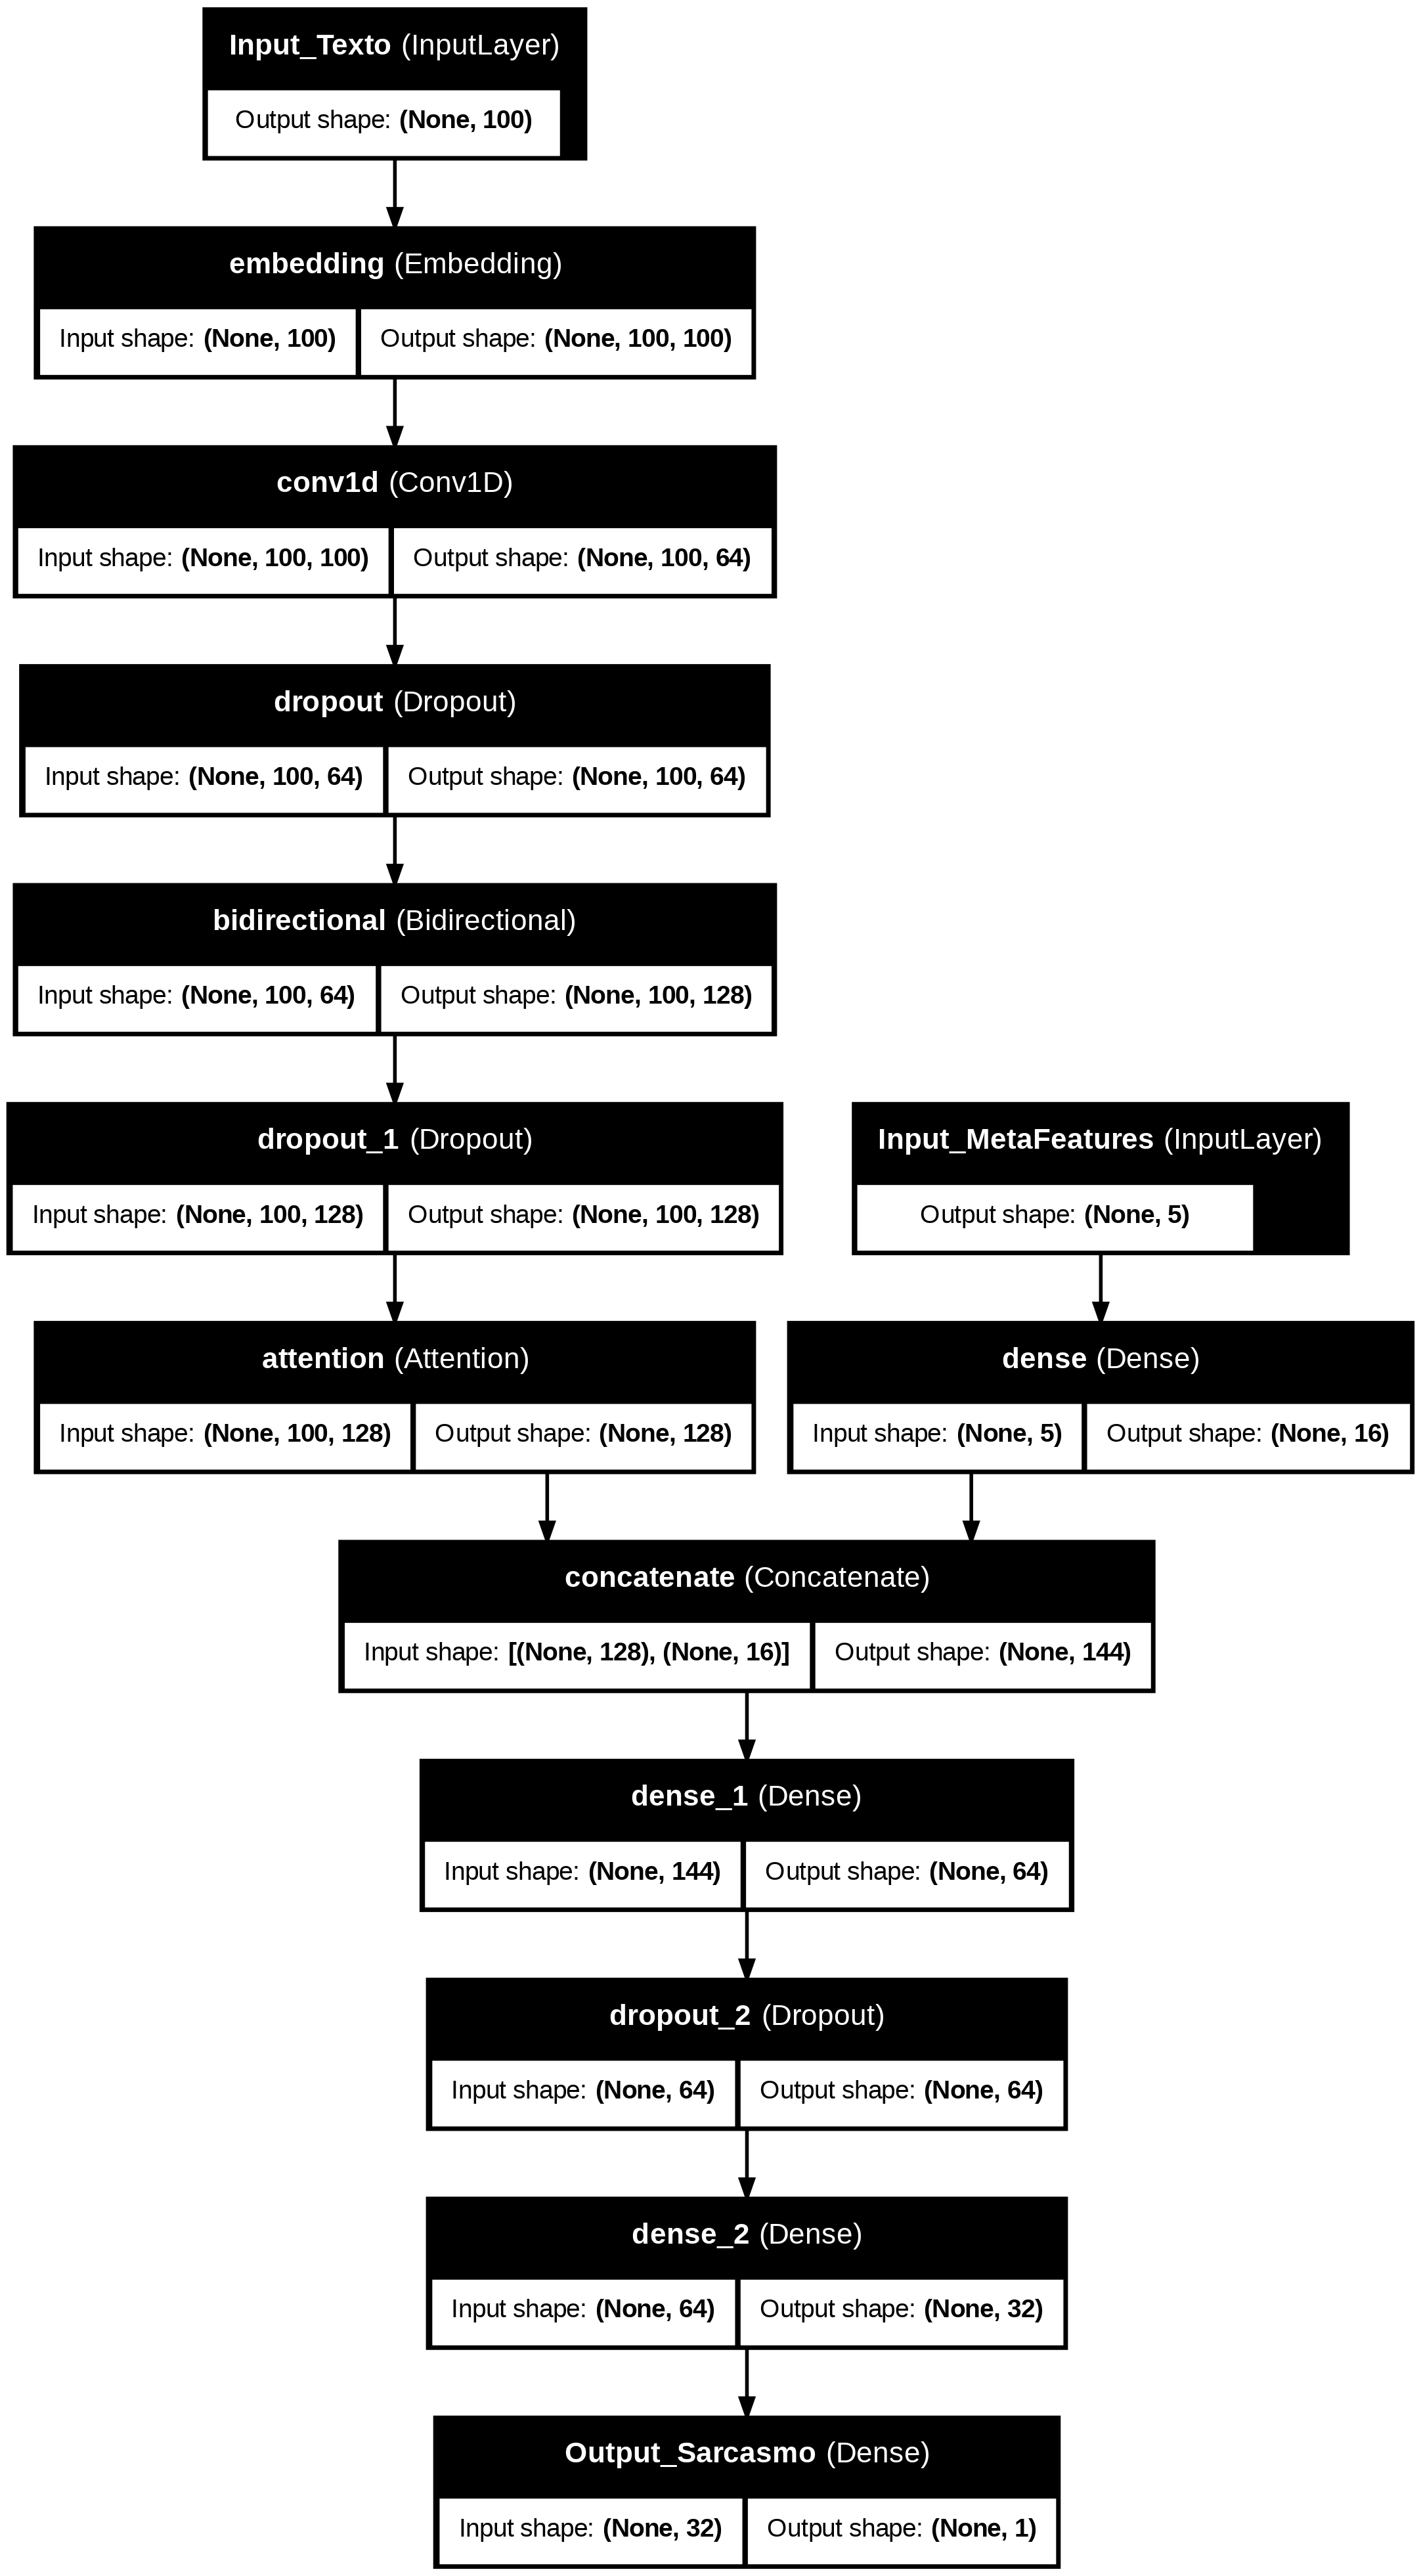

In [ ]:
# --- 6. COMPILACIÓN DEL MODELO ---
model = Model(inputs=[input_text, input_meta], outputs=output)

# Optimizador Adam con learning rate estándar
optimizer = Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', # Función de error para sí/no
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# --- RESUMEN DE LA ARQUITECTURA ---
print("Modelo Híbrido Construido Exitosamente.")
model.summary()

# Visualizar el diagrama
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

#Fase 5 (Evalución)

##PASO 1: CONFIGURACIÓN Y ENTRENAMIENTO

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

###DEFINIR CALLBACKS (SALVAVIDAS)

In [ ]:
# 1. DEFINIR CALLBACKS (SALVAVIDAS)
# ==========================================
# Detener si no mejora la validación en 3 épocas seguidas
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

# Guardar el mejor modelo en un archivo
checkpoint = ModelCheckpoint('mejor_modelo_sarcasmo.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

###EJECUTAR EL ENTRENAMIENTO (FIT)

In [ ]:
# 2. EJECUTAR EL ENTRENAMIENTO (FIT)
# ==========================================
# BATCH_SIZE: Cuántos tweets procesa antes de actualizar sus neuronas (32 o 64 es estándar)
# EPOCHS: Cuántas veces revisará el dataset completo (ponemos 10, pero EarlyStopping puede pararlo antes)

print("--- INICIANDO ENTRENAMIENTO DEL MODELO HÍBRIDO ---")
history = model.fit(
    x=[X_train_seq, X_train_meta],  # ENTRAMOS LAS DOS RAMAS (Texto y Meta)
    y=y_train,                      # La etiqueta correcta
    validation_data=([X_val_seq, X_val_meta], y_val), # Datos para validar examen
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, checkpoint] # Activamos los salvavidas
)

--- INICIANDO ENTRENAMIENTO DEL MODELO HÍBRIDO ---
Epoch 1/10
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9316 - loss: 0.1770 - precision: 0.9449 - recall: 0.9721
Epoch 1: val_loss improved from inf to 0.06185, saving model to mejor_modelo_sarcasmo.keras
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 329s 144ms/step - accuracy: 0.9316 - loss: 0.1769 - precision: 0.9449 - recall: 0.9721 - val_accuracy: 0.9778 - val_loss: 0.0619 - val_precision: 0.9994 - val_recall: 0.9718
Epoch 2/10
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9851 - loss: 0.0421 - precision: 0.9953 - recall: 0.9853
Epoch 2: val_loss improved from 0.06185 to 0.05539, saving model to mejor_modelo_sarcasmo.keras
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 321s 143ms/step - accuracy: 0.9851 - loss: 0.0421 - precision: 0.9953 - recall: 0.9853 - val_accuracy: 0.9816 - val_loss: 0.0554 - val_precision: 0.9962 - val_recall: 0.9799
Epoch 3/10
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9920 - loss: 0.0240 - preci

###VISUALIZACIÓN DE CURVAS DE APRENDIZAJE

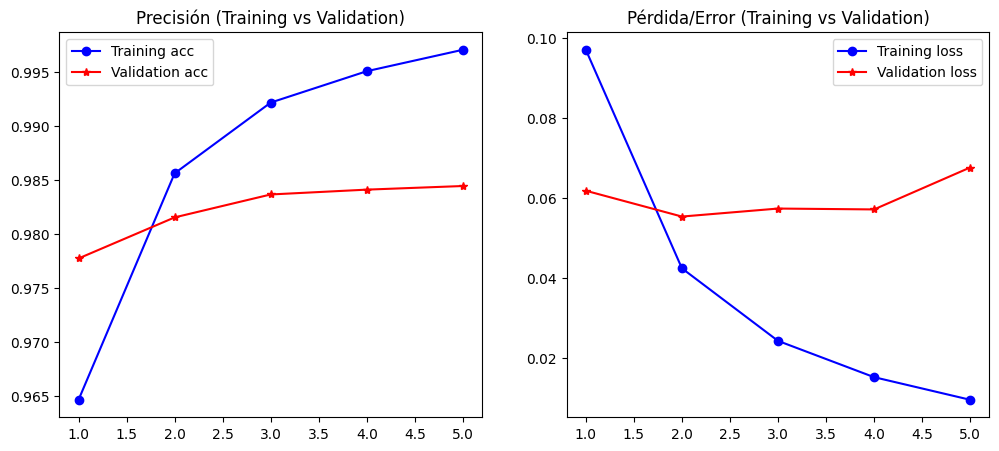

In [ ]:
# 3. VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
# ==========================================
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Gráfica de Precisión (Accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'r*-', label='Validation acc')
    plt.title('Precisión (Training vs Validation)')
    plt.legend()

    # Gráfica de Pérdida (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Pérdida/Error (Training vs Validation)')
    plt.legend()

    plt.show()

plot_history(history)

##PASO 2: EVALUACIÓN FINAL (TEST SET)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np


--- GENERANDO PREDICCIONES EN EL SET DE PRUEBA ---
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step


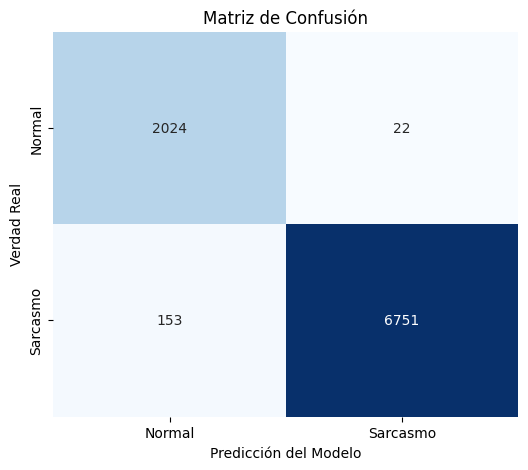


--- REPORTE DE CLASIFICACIÓN (Métricas de Tesis) ---
              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96      2046
    Sarcasmo       1.00      0.98      0.99      6904

    accuracy                           0.98      8950
   macro avg       0.96      0.98      0.97      8950
weighted avg       0.98      0.98      0.98      8950



In [ ]:
print("\n--- GENERANDO PREDICCIONES EN EL SET DE PRUEBA ---")

# 1. Predecir probabilidades (devuelve valor entre 0 y 1)
y_pred_probs = model.predict([X_test_seq, X_test_meta])

# 2. Convertir probabilidad a clase (Si > 0.5 es Sarcasmo (1), si no es Normal (0))
y_pred = (y_pred_probs > 0.5).astype(int)

# 3. MATRIZ DE CONFUSIÓN
# ==========================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Sarcasmo'],
            yticklabels=['Normal', 'Sarcasmo'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Verdad Real')
plt.title('Matriz de Confusión')
plt.show()

# 4. REPORTE MÉTRICO DETALLADO
# ==========================================
print("\n--- REPORTE DE CLASIFICACIÓN (Métricas de Tesis) ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Sarcasmo']))

In [ ]:
# Verificación de "Fuga de Información" (Data Leakage)
# Buscamos si las palabras clave de la etiqueta están dentro del texto limpio

palabras_trampa = ['sarcasm', 'sarcastic', 'irony', 'ironic', '#sarcasm', '#irony', '#not']

print("--- Auditoría de Texto (Buscando pistas obvias) ---")
for palabra in palabras_trampa:
    conteo = df_total['tweet'].str.contains(palabra, case=False).sum()
    print(f"Tweets que contienen la palabra '{palabra}': {conteo}")

--- Auditoría de Texto (Buscando pistas obvias) ---
Tweets que contienen la palabra 'sarcasm': 32730
Tweets que contienen la palabra 'sarcastic': 2012
Tweets que contienen la palabra 'irony': 26174
Tweets que contienen la palabra 'ironic': 8973
Tweets que contienen la palabra '#sarcasm': 32690
Tweets que contienen la palabra '#irony': 26065
Tweets que contienen la palabra '#not': 497


In [ ]:
# Ver los errores para entender la lógica del modelo
print("--- ANÁLISIS DE ERRORES (FALSOS POSITIVOS) ---")
# Buscamos índices donde Realidad es 0 (Normal) pero Predicción es 1 (Sarcasmo)
errores_idx = [i for i, (real, pred) in enumerate(zip(y_test, y_pred)) if real == 0 and pred == 1]

if errores_idx:
    print(f"El modelo se equivocó en estos tweets (Dijo Sarcasmo, era Normal):")
    for i in errores_idx[:5]: # Mostramos hasta 5
        print(f"\nTweet Original: {df_total.iloc[y_test.index[i]]['tweet']}")
        print(f"Procesado: {X_test_seq[i]}") # (Esto saldrá en números, pero nos sirve el original)
else:
    print("No hubo Falsos Positivos.")

--- ANÁLISIS DE ERRORES (FALSOS POSITIVOS) ---
El modelo se equivocó en estos tweets (Dijo Sarcasmo, era Normal):

Tweet Original: Inter Arma Enim Silent Leges (In Times of War, The Law Falls Silent) #pilgrim #peace #war #love #hope #charity        http://t.co/olOhyV1tEZ
Procesado: [ 357  936  303 9696    2 1446 2611 8982 4099 2859    1   10    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

Tweet Original: #pain #Painkillers #drugs http://t.co/yhJfOI7iNG (Reuters Health) - A new analysis of existing research finds tha… http://t.co/QePQK7fhkY
Procesado: [623   8   2 204 592  42 666   0   0   0  

--- INICIANDO PRUEBA FINAL CON CONJUNTO DE TEST (X_test) ---
Calculando métricas...
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9796 - loss: 0.0546 - precision: 0.9967 - recall: 0.9769

Exactitud (Accuracy) en Test: 98.04%
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

  Normal (0)       0.93      0.99      0.96      2046
Sarcasmo (1)       1.00      0.98      0.99      6904

    accuracy                           0.98      8950
   macro avg       0.96      0.98      0.97      8950
weighted avg       0.98      0.98      0.98      8950



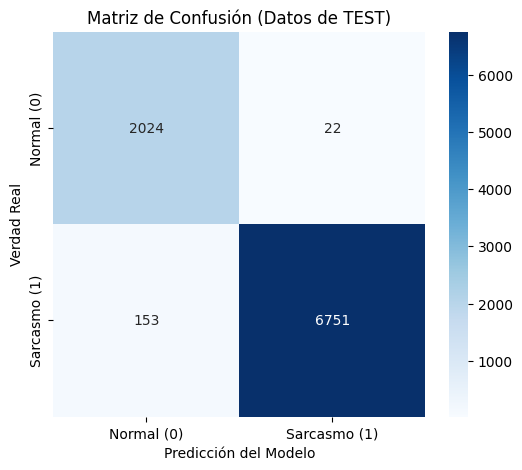

In [ ]:
# ======================
# 3. EVALUACIÓN FINAL
# ======================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print("--- INICIANDO PRUEBA FINAL CON CONJUNTO DE TEST (X_test) ---")

# A. Evaluación Numérica Directa
# El modelo nos dirá su 'Loss' y 'Accuracy'
print("Calculando métricas...")
results = model.evaluate([X_test_seq, X_test_meta], y_test, verbose=1)
print(f"\nExactitud (Accuracy) en Test: {results[1]*100:.2f}%")

# B. Generar Predicciones Individuales
# El modelo devuelve probabilidades (ej: 0.95, 0.03).
# Redondeamos: >0.5 es Sarcasmo (1), <0.5 es Normal (0).
y_pred_prob = model.predict([X_test_seq, X_test_meta])
y_pred = (y_pred_prob > 0.5).astype(int)

# C. Reporte Detallado por Clase
print("\n--- Reporte de Clasificación ---")
target_names = ['Normal (0)', 'Sarcasmo (1)']
print(classification_report(y_test, y_pred, target_names=target_names))

# D. Matriz de Confusión Visual (Test)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
# Dibujamos el mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Matriz de Confusión (Datos de TEST)')
plt.ylabel('Verdad Real')
plt.xlabel('Predicción del Modelo')
plt.show()

In [ ]:
# ==========================================
# 4. GUARDADO FINAL DE ARTEFACTOS
# ==========================================
import os
import pickle

print("--- GUARDANDO EL SISTEMA COMPLETO EN DRIVE ---")

# Define la ruta de tu carpeta en Drive
ruta_proyecto = '/content/drive/MyDrive/Proyecto_Sarcasmo'

# Verificar que la carpeta exista, si no, crearla
if not os.path.exists(ruta_proyecto):
    os.makedirs(ruta_proyecto)
    print(f"Carpeta creada: {ruta_proyecto}")

# 1. Guardar el MODELO (El Cerebro)
ruta_modelo = os.path.join(ruta_proyecto, 'modelo_sarcasmo_tesis_final.keras')
model.save(ruta_modelo)
print(f"Modelo guardado exitosamente en: {ruta_modelo}")

# 2. Guardar el TOKENIZADOR (El Diccionario)
# Vital: Sin esto, no podremos convertir texto nuevo a números mañana.
ruta_tokenizer = os.path.join(ruta_proyecto, 'tokenizer.pickle')
with open(ruta_tokenizer, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Tokenizador guardado en: {ruta_tokenizer}")

# 3. Guardar el SCALER (La Regla de Medir)
# Vital: Para que las features auxiliares (mayúsculas, etc.) tengan la misma escala.
ruta_scaler = os.path.join(ruta_proyecto, 'scaler.pickle')
with open(ruta_scaler, 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Scaler guardado en: {ruta_scaler}")

print("\n¡PROCESO FINALIZADO! tesis respaldada.")

In [ ]:
import pandas as pd
import numpy as np

print("--- 🛠️ AUDITORÍA DE CASOS (VERSIÓN FINAL) ---")

# 1. Función para asegurar que tratamos con listas simples
def aplanar(datos):
    if hasattr(datos, 'values'):
        datos = datos.values
    if isinstance(datos, np.ndarray):
        return datos.reshape(-1)
    return datos

# 2. Obtenemos los datos (Recortando al tamaño del más pequeño para evitar errores)
txt_real = aplanar(X_test)
etq_real = aplanar(y_test)
preds    = y_pred.flatten()
probs    = y_pred_prob.flatten()

min_len = min(len(txt_real), len(etq_real), len(preds))
print(f"🔄 Analizando los primeros {min_len} registros disponibles...")

# 3. Creamos el DataFrame de análisis
df_analisis = pd.DataFrame({
    'Tweet_Original': txt_real[:min_len],
    'Etiqueta_Real': etq_real[:min_len],
    'Prediccion_Modelo': preds[:min_len],
    'Probabilidad': probs[:min_len]
})

# 4. Clasificación de Casos (Usando nombres consistentes)
# TP: Verdaderos Positivos (Sarcasmo detectado bien)
tp = df_analisis[(df_analisis['Etiqueta_Real']==1) & (df_analisis['Prediccion_Modelo']==1)]

# TN: Verdaderos Negativos (Normal detectado bien)
tn = df_analisis[(df_analisis['Etiqueta_Real']==0) & (df_analisis['Prediccion_Modelo']==0)]

# FP: Falsos Positivos (Era Normal, dijo Sarcasmo)
fp = df_analisis[(df_analisis['Etiqueta_Real']==0) & (df_analisis['Prediccion_Modelo']==1)]

# FN: Falsos Negativos (Era Sarcasmo, dijo Normal)
fn = df_analisis[(df_analisis['Etiqueta_Real']==1) & (df_analisis['Prediccion_Modelo']==0)]

# 5. Función auxiliar para buscar SOLO TEXTO (Evita los números 0.222)
def obtener_ejemplo_valido(dataframe, nombre_caso):
    for texto in dataframe['Tweet_Original']:
        # Solo devolvemos si es un texto (string) y tiene una longitud decente (>10)
        if isinstance(texto, str) and len(texto) > 10:
            return texto
    return "No se encontró un ejemplo de texto válido en este cruce de datos."

print("\n--- 📝 COPIA ESTOS TEXTOS A TU TABLA 2 ---")

# Buscamos el primer ejemplo válido de texto para cada categoría
txt_tp = obtener_ejemplo_valido(tp, "Acierto Sarcasmo")
txt_tn = obtener_ejemplo_valido(tn, "Acierto Normal")
txt_fn = obtener_ejemplo_valido(fn, "Error Falso Negativo")
txt_fp = obtener_ejemplo_valido(fp, "Error Falso Positivo")

print(f"\nACIERTO (Sarcasmo): \n\"{txt_tp}\"")
print(f"\nACIERTO (Normal): \n\"{txt_tn}\"")
print(f"\nERROR (Falso Negativo - Se le escapó): \n\"{txt_fn}\"")
print(f"\nERROR (Falso Positivo - Falsa Alarma): \n\"{txt_fp}\"")

--- 🛠️ AUDITORÍA DE CASOS (VERSIÓN FINAL) ---
🔄 Analizando los primeros 8950 registros disponibles...

--- 📝 COPIA ESTOS TEXTOS A TU TABLA 2 ---

ACIERTO (Sarcasmo): 
"@HGSupport Poor email deliverability fr HG shared servers is why we have to use Mandrill to get email to customers in the 1st place. #irony"

ACIERTO (Normal): 
"It's too bright out #Irony @TheFunRun #FunRun2 http://t.co/tl9NuqFo95"

ERROR (Falso Negativo - Se le escapó): 
"Great to see such a professional set up @EasirentCarHire at London Heathrow! #Sarcasm http://t.co/cG6vWkUwSu"

ERROR (Falso Positivo - Falsa Alarma): 
"thanks not mentioning territorial restriction"
